In [8]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [9]:
models_name = [
    "basic-mini",
    "basic-base",
    "basic-large",
    "art-mini",
    "art-base"
]
data = {}
for model_name in models_name:
    data[model_name] = {}
    data[model_name]["metrics"] = pd.read_csv(f"../benchmarks/multilingual_results_{model_name}.csv")
    data[model_name]["positions"] = json.load(open(f"../benchmarks/positions_specific_focus_{model_name}.json"))

In [10]:
def getdf(model_name, focus=None):
    if focus is None:
        df = data[model_name]["metrics"] 
    else:
        df = data[model_name]["metrics"][data[model_name]["metrics"]["focus"] == focus]
    df["model_name"] = model_name
    return df

def getjson(model_name, focus):
    if focus is None:
        positions_merged = {}
        for lang in data[model_name]["positions"]:
            positions_merged[lang] = []
            for focus in data[model_name]["positions"][lang]:
                positions_merged[lang].extend(data[model_name]["positions"][lang][focus])
        return positions_merged
    else:
        positions = {}
        for lang in data[model_name]["positions"]:
            positions[lang] = data[model_name]["positions"][lang][focus]
        return positions

def histogram_positions(model_name, focus):
    positions = getjson(model_name, focus)
    langs = list(positions.keys())
    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))
    for i, lang in enumerate(langs):
        axs[i].hist(positions[lang], bins=20, edgecolor='black')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Frequency")
    plt.suptitle(f"Histogram of positions for {model_name} and {focus}")
    plt.tight_layout()
    plt.show()

def cdf_positions(model_name, focus):
    positions = getjson(model_name, focus) 
    langs = list(positions.keys())

    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))

    if len(langs) == 1:
        axs = [axs]

    # Get overall max position
    max_position = 0
    for lang in langs:
        max_position = max(max_position, max(positions[lang]))

    for i, lang in enumerate(langs):
        data = np.sort(positions[lang])
        cdf = np.arange(1, len(data) + 1) / len(data)
        # Fill cdf with 1 so that the last point is at the max position
        
        while data[-1] < max_position:
            data = np.concatenate([data, [max_position]])
            cdf = np.concatenate([cdf, [1]])

        percentile_90 = np.percentile(data, 90)
        percentile_95 = np.percentile(data, 95)
        percentile_99 = np.percentile(data, 99)

        # Vlines for 90, 95, 99 percentile
        axs[i].vlines(percentile_90, 0, 1, color='r', linestyle='--', label='90th Percentile')
        axs[i].vlines(percentile_95, 0, 1, color='g', linestyle='--', label='95th Percentile')
        axs[i].vlines(percentile_99, 0, 1, color='y', linestyle='--', label='99th Percentile')
        

        axs[i].plot(data, cdf, linestyle='-', color='b', label='CDF')
        axs[i].set_title(lang)
        axs[i].set_xlabel("Position")
        axs[i].set_ylabel("Cumulative Frequency")
        axs[i].grid(True, linestyle='--', alpha=0.5)
        axs[i].set_xlim(0, max_position)
        axs[i].legend(loc='lower right')

    plt.suptitle(f"CDF of positions for {model_name} and {focus}")
    plt.subplots_adjust(top=0.85)
    plt.tight_layout()
    plt.show()

In [11]:
# Add to the metrics the percentile 50, 90, 95, 99
for model_name in models_name:
    print("Done ", model_name)
    for focus in data[model_name]["metrics"]["focus"].unique():
        if focus=="all_focus":
            continue
        df = getdf(model_name, focus)
        json_data = getjson(model_name, focus)
        for lang in json_data.keys():
            positions = json_data[lang]
            # Create a boolean mask for the correct rows
            mask = (df["model_name"] == model_name) & (df["lang"] == lang)
            # Apply the mask to update the percentiles
            df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
            df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
            df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
            df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
            df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

    # Add for all_focus
    df = getdf(model_name, None)
    json_data = getjson(model_name, None)
    for lang in json_data.keys():
        positions = json_data[lang]
        # Create a boolean mask for the correct rows
        mask = (df["model_name"] == model_name) & (df["lang"] == lang)
        # Apply the mask to update the percentiles
        df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
        df.loc[mask, "percentile_75"] = np.percentile(positions, 75)
        df.loc[mask, "percentile_90"] = np.percentile(positions, 90)
        df.loc[mask, "percentile_95"] = np.percentile(positions, 95)
        df.loc[mask, "percentile_99"] = np.percentile(positions, 99)

Done  basic-mini
Done  basic-base
Done  basic-large
Done  art-mini
Done  art-base


C:\Users\victo\AppData\Local\Temp\ipykernel_16552\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name
C:\Users\victo\AppData\Local\Temp\ipykernel_16552\3763733635.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, "percentile_50"] = np.percentile(positions, 50)
C:\Users\victo\AppData\Local\Temp\ipykernel_16552\3763733635.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [12]:
all_focus_df = pd.concat([getdf(model_name, "all_focus") for model_name in models_name])
all_focus_df

C:\Users\victo\AppData\Local\Temp\ipykernel_16552\4104679395.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model_name"] = model_name


,lang,focus,loss,average_position,mrr,recall@1,recall@5,recall@10,nDCG@1,nDCG@5,nDCG@10,model_name,percentile_50,percentile_75,percentile_90,percentile_95,percentile_99
4,FR,all_focus,3.212070,22.440508,0.375068,0.249967,0.506223,0.645225,0.249967,0.383883,0.429479,basic-mini,6.0,25.00,78.0,134.00,223.05
9,EN,all_focus,2.014006,7.820168,0.533790,0.401566,0.685610,0.824177,0.401566,0.550926,0.595932,basic-mini,3.0,8.00,21.0,37.00,109.23
14,NL,all_focus,4.068309,30.460115,0.267472,0.147865,0.392144,0.514081,0.147865,0.273970,0.313410,basic-mini,11.0,43.00,103.7,151.70,267.47
4,FR,all_focus,1.337325,14.970489,0.459432,0.325652,0.598247,0.708395,0.325652,0.473705,0.510153,basic-base,4.0,16.00,51.0,84.05,174.05
9,EN,all_focus,0.549765,4.394852,0.646741,0.508839,0.814597,0.904872,0.508839,0.675704,0.705188,basic-base,2.0,4.00,11.0,18.00,47.00
14,NL,all_focus,1.833276,16.913578,0.373640,0.233332,0.528469,0.678902,0.233332,0.387257,0.436057,basic-base,5.0,18.00,53.0,90.40,166.11
4,FR,all_focus,0.890211,13.029739,0.477068,0.340812,0.640918,0.736227,0.340812,0.500155,0.530997,basic-large,3.0,13.00,43.0,73.00,157.46
9,EN,all_focus,0.272292,4.074256,0.665969,0.530846,0.843441,0.909378,0.530846,0.700294,0.721489,basic-large,2.0,4.00,11.0,19.00,39.94
14,NL,all_focus,1.315949,17.049171,0.380494,0.243245,0.543767,0.683962,0.243245,0.397551,0.442820,basic-large,5.0,17.00,55.7,93.00,188.41
4,FR,all_focus,1.105006,2.357923,0.748386,0.623060,0.910711,0.967181,0.623060,0.781655,0.800330,art-mini,1.0,3.00,6.0,9.00,19.00


In [13]:
"""
Columns are:
lang	focus	loss	average_position	mrr	recall@1	recall@5	recall@10	nDCG@1	nDCG@5	nDCG@10
Plot mrr for each model, one color per lang
"""
def plot_metric_per_model_per_lang(metric_name, y_lim=None):
    langs = all_focus_df["lang"].unique()
    fig, axs = plt.subplots(1, len(langs), figsize=(15, 5))
    for i, lang in enumerate(langs):
        axs[i].bar(all_focus_df[all_focus_df["lang"] == lang]["model_name"], all_focus_df[all_focus_df["lang"] == lang][metric_name])
        axs[i].set_title(lang)
        axs[i].set_xlabel("Model")
        axs[i].set_ylabel(metric_name)
        axs[i].set_xticks(range(len(models_name)))
        axs[i].set_xticklabels(models_name, rotation=45)
        if y_lim is not None:
            axs[i].set_ylim(y_lim)
        # Add a text label on each bar
        for j, bar in enumerate(axs[i].patches):
            axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.2f}", ha="center", va="bottom")
    plt.suptitle(metric_name)
    plt.tight_layout()
    plt.savefig(f"../figures/benchmarks_figures/{metric_name}.pdf")
    plt.show()

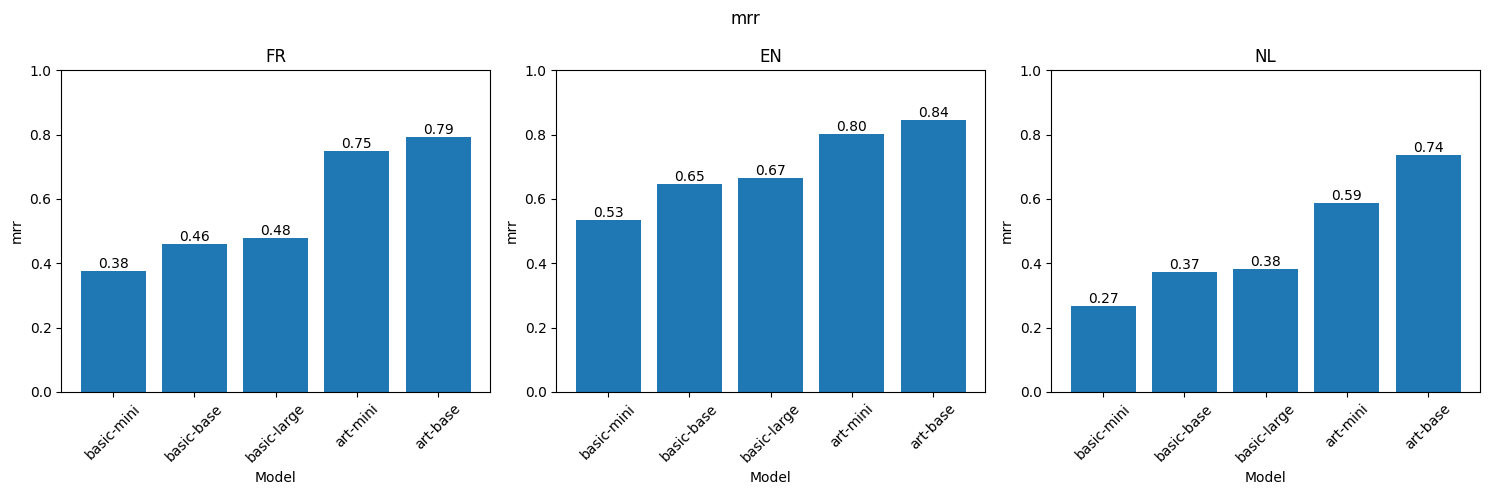

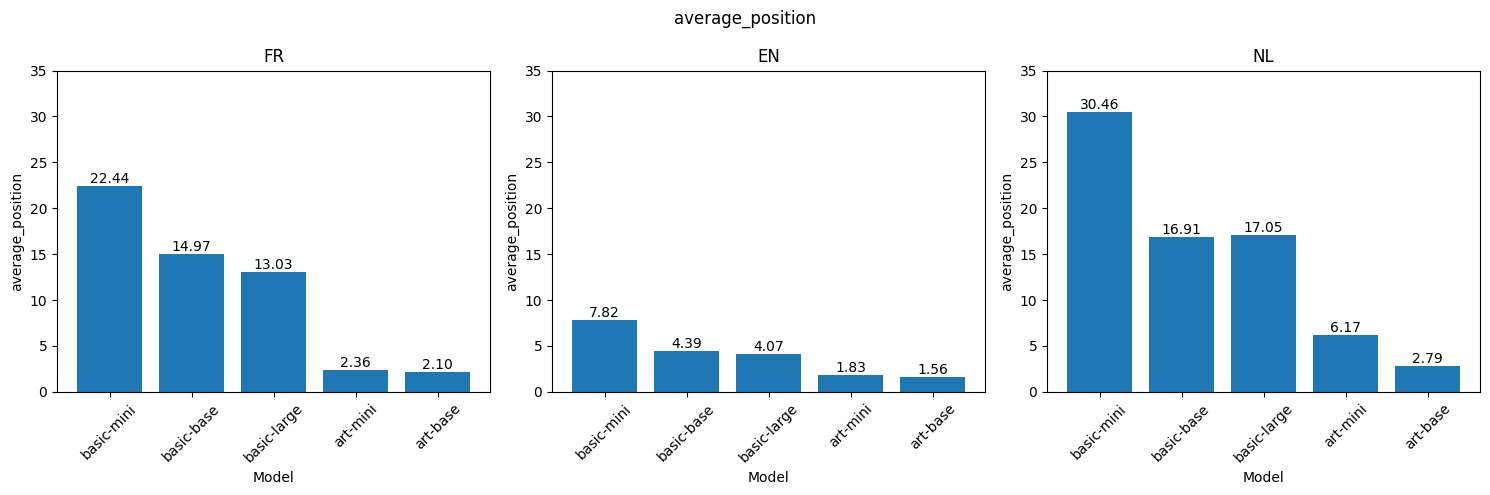

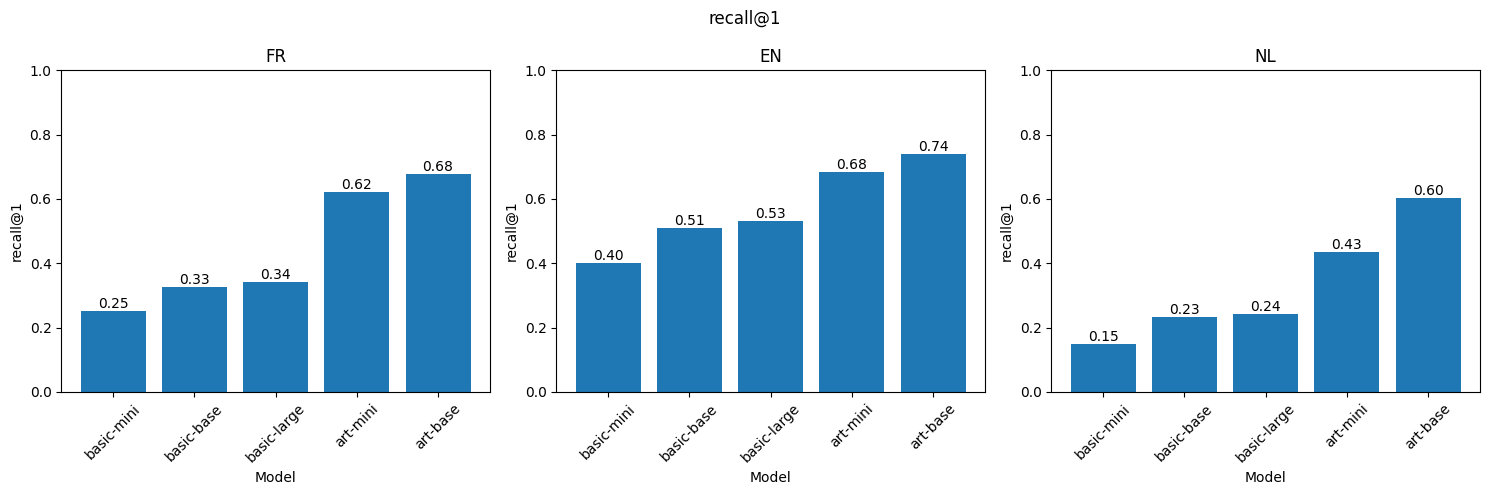

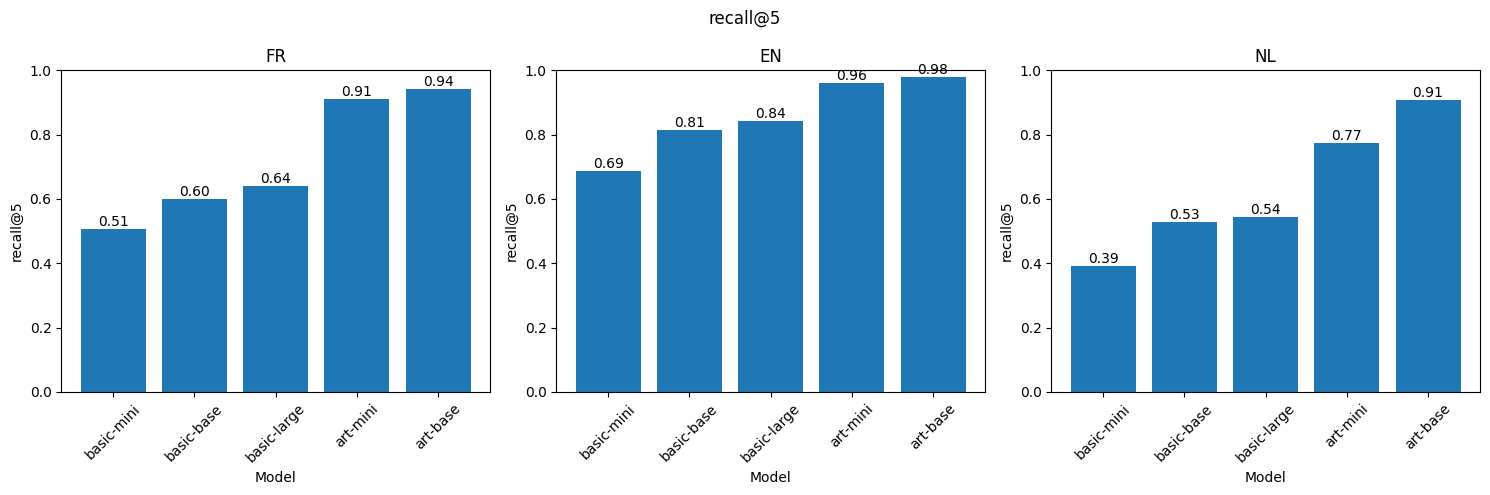

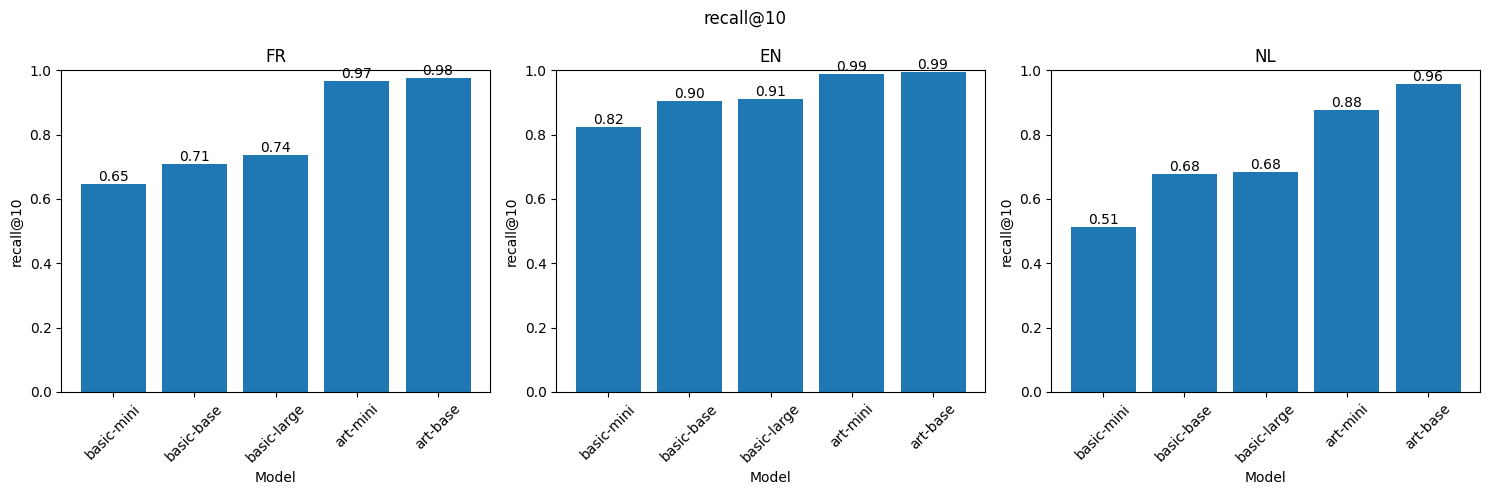

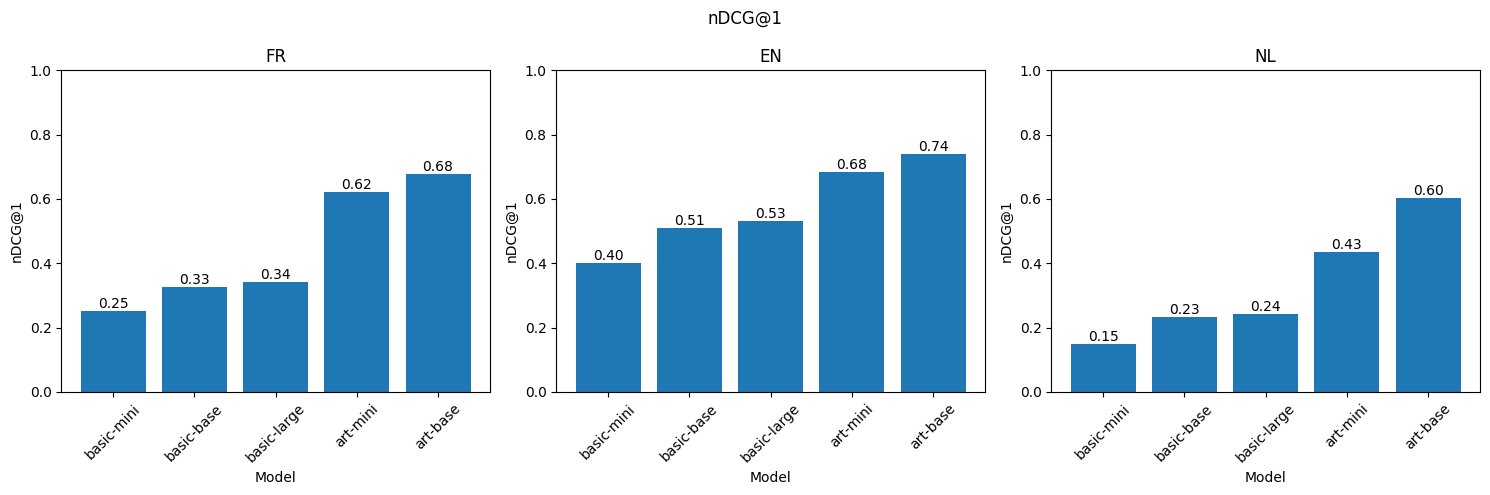

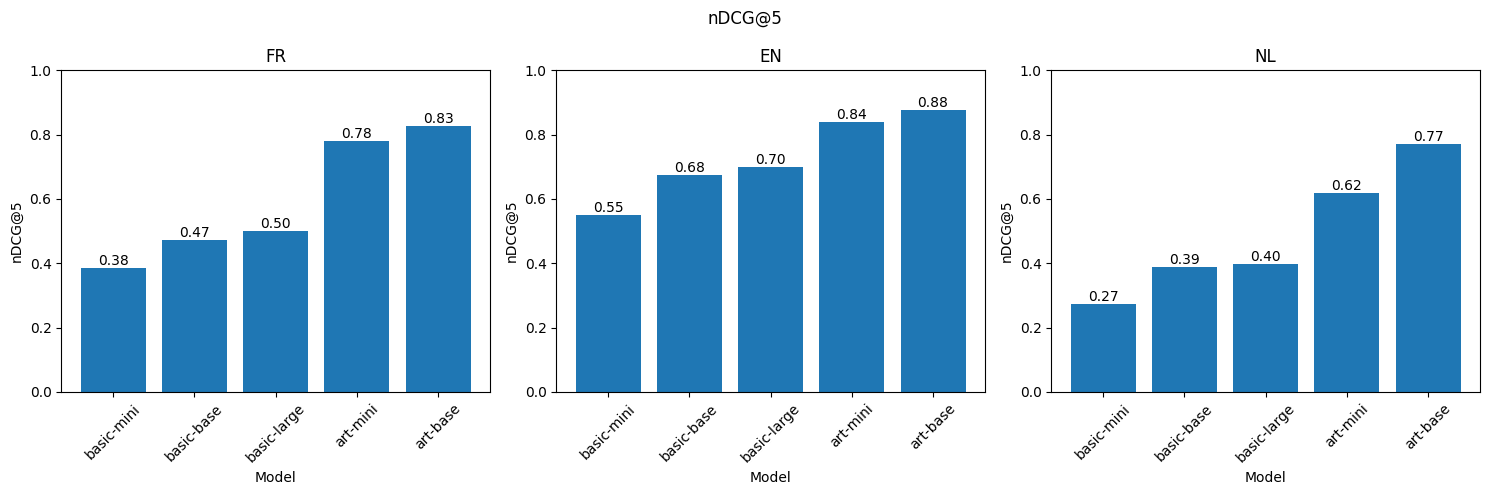

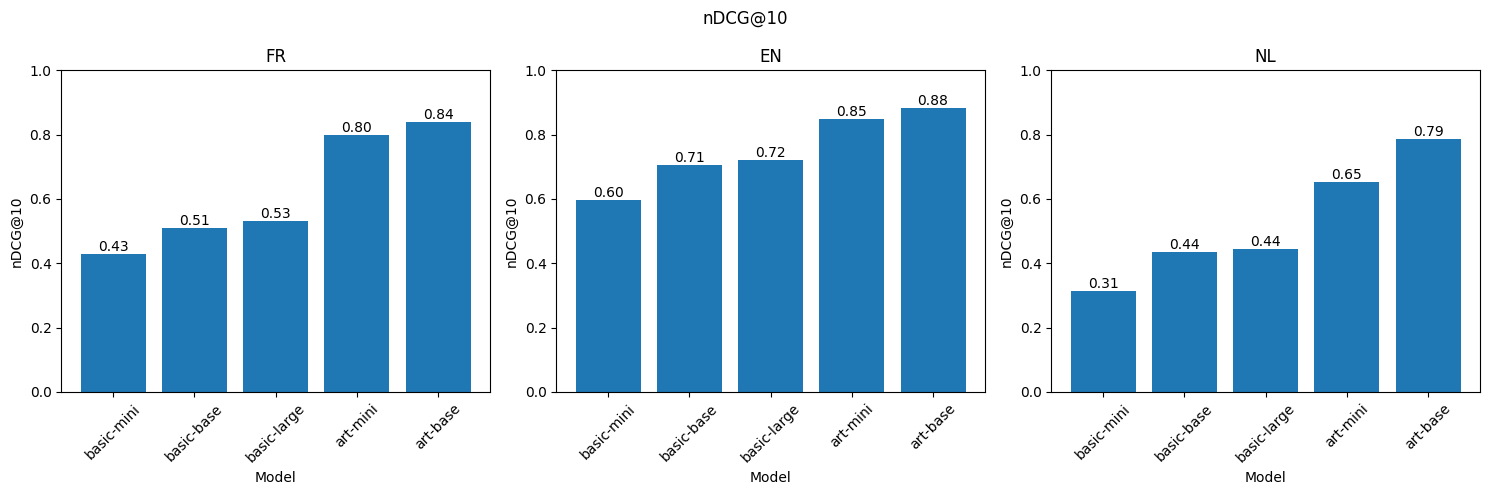

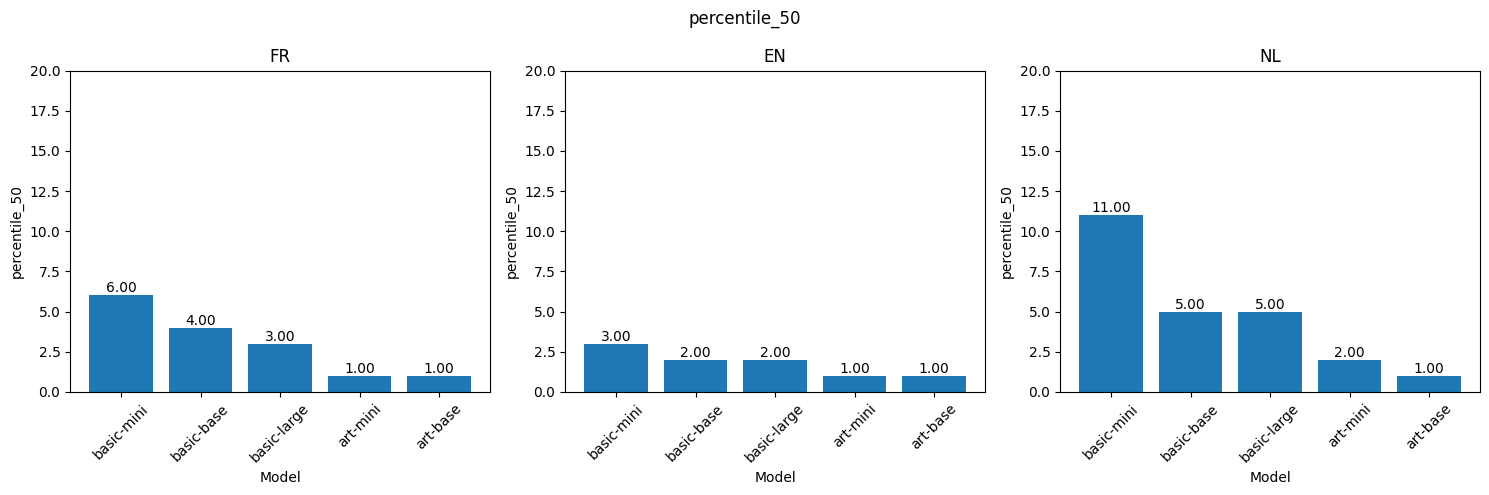

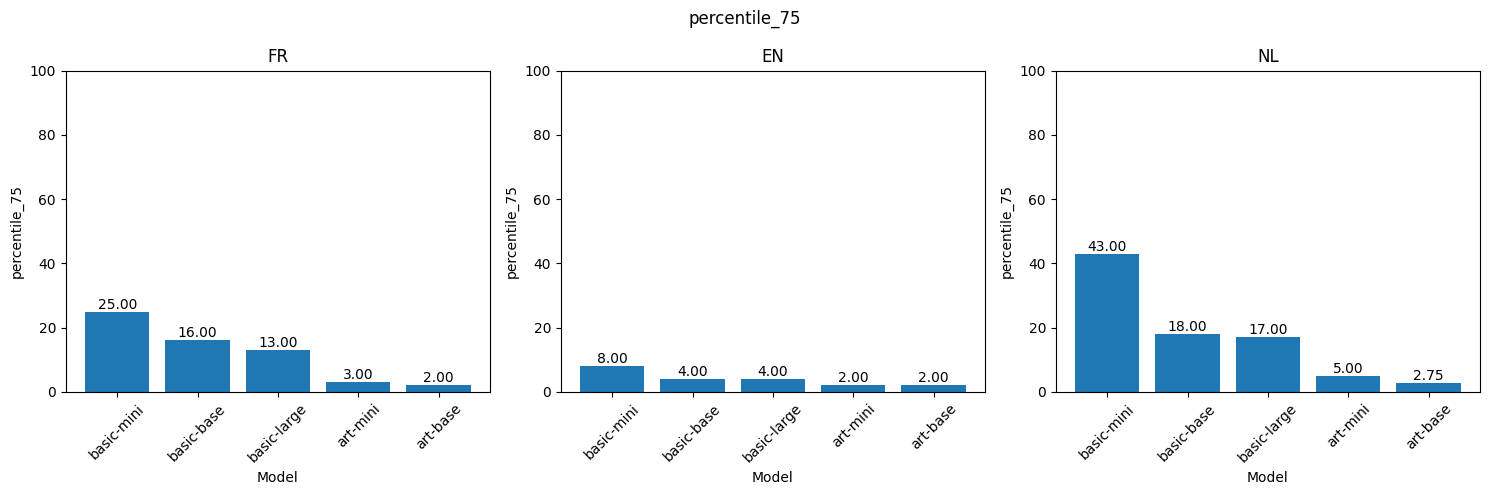

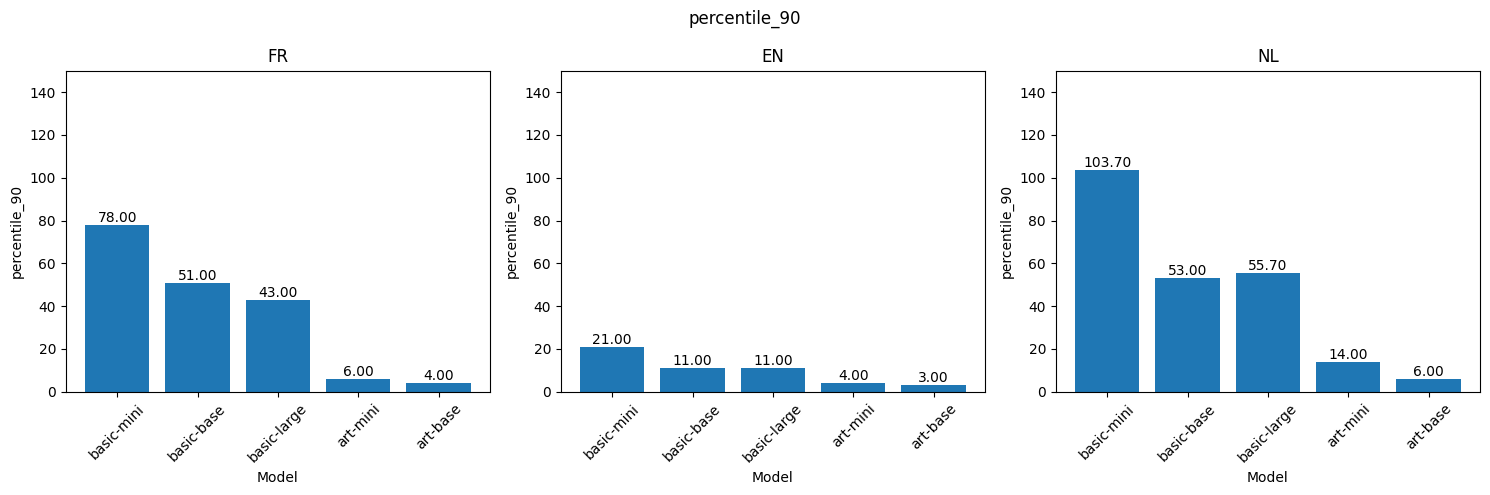

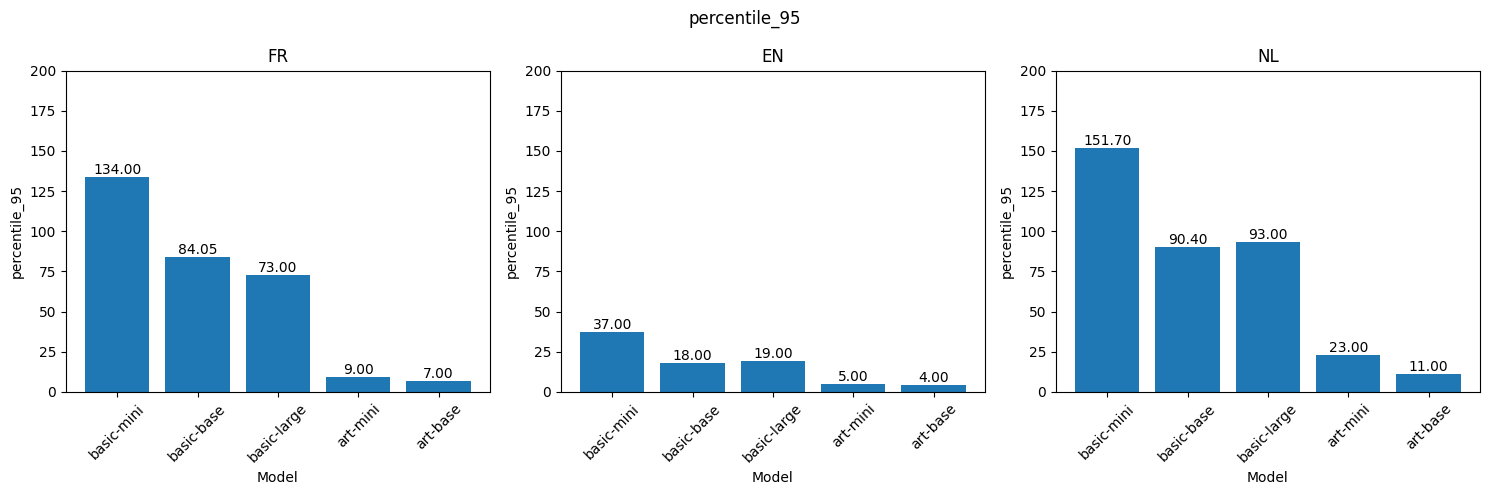

In [14]:
import os
os.makedirs("../figures/benchmarks_figures", exist_ok=True)
metrics = {
    "mrr": (0, 1),
    "average_position": (0, 35),
    "recall@1": (0, 1),
    "recall@5": (0, 1),
    "recall@10": (0, 1),
    "nDCG@1": (0, 1),
    "nDCG@5": (0, 1),
    "nDCG@10": (0, 1),
    "percentile_50": (0, 20),
    "percentile_75": (0, 100),
    "percentile_90": (0, 150),
    "percentile_95": (0, 200),
}
for metric in metrics:
    plot_metric_per_model_per_lang(metric, metrics[metric])

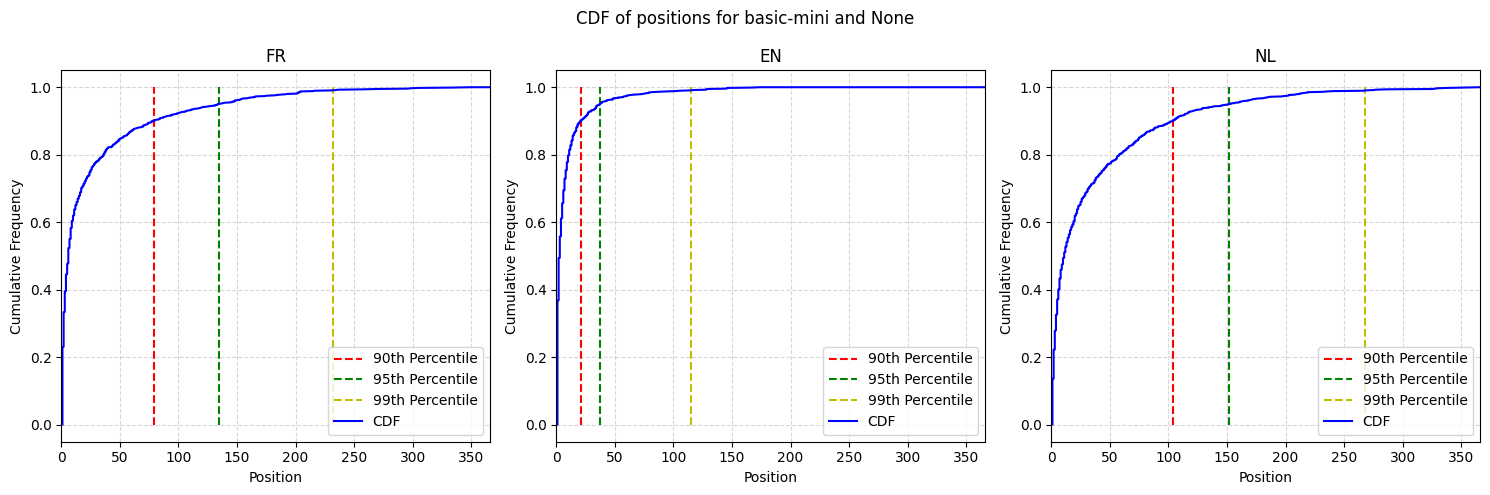

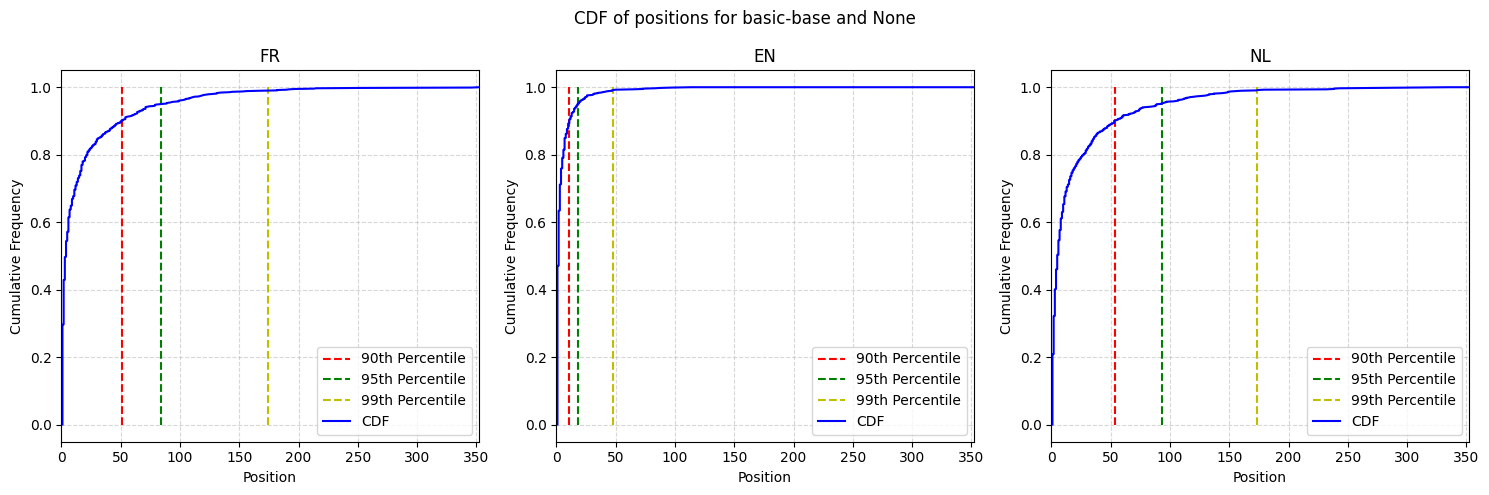

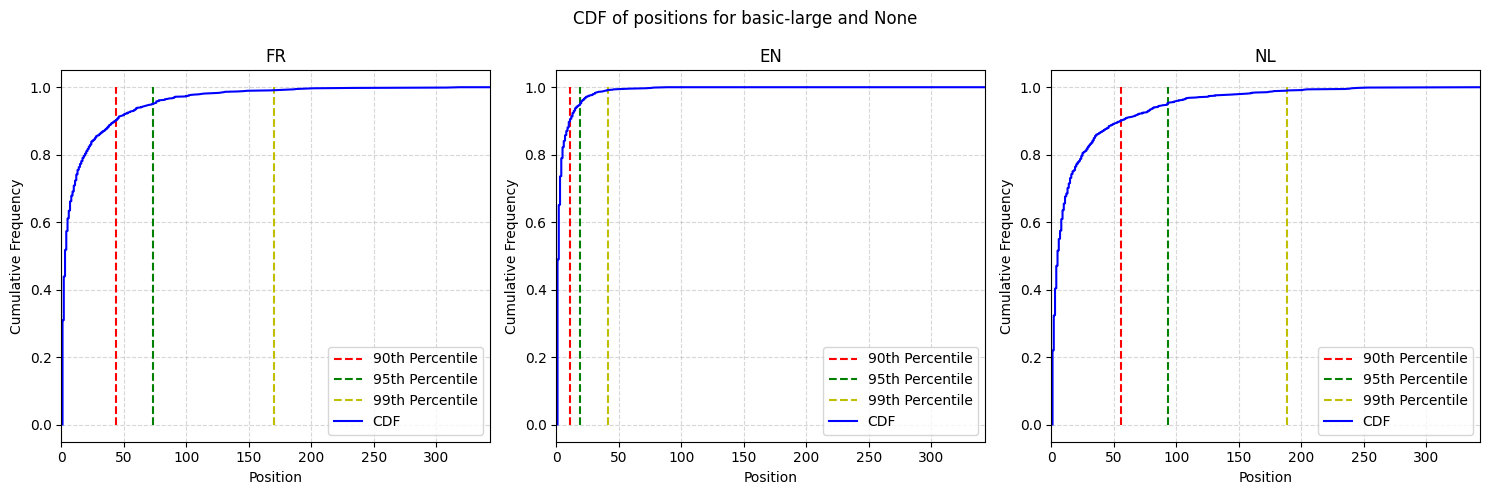

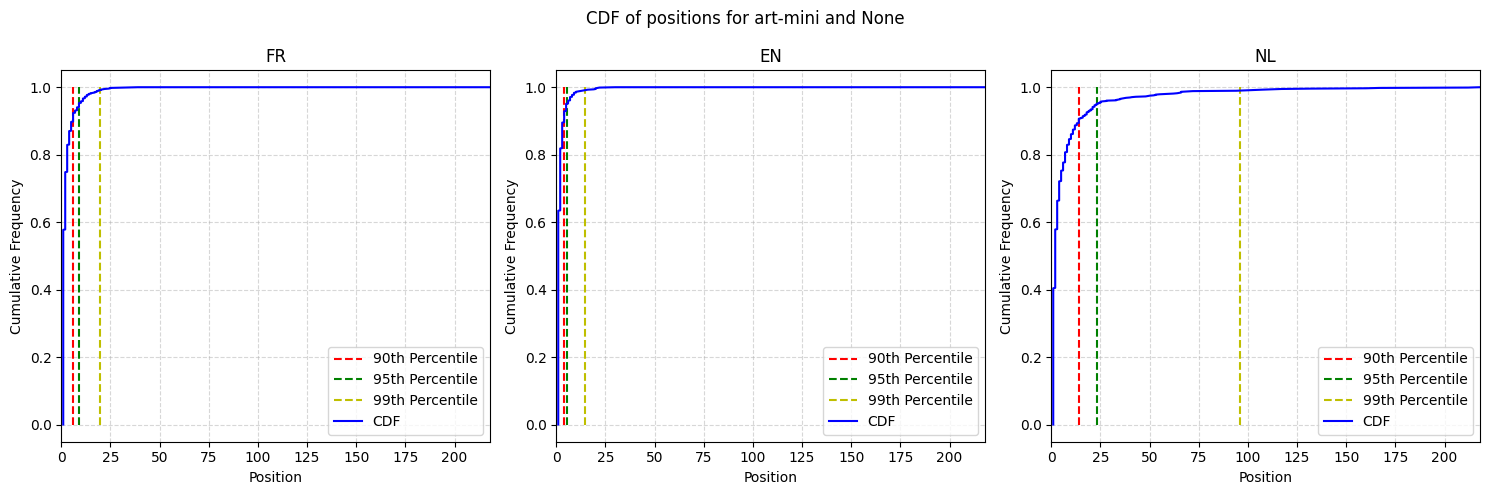

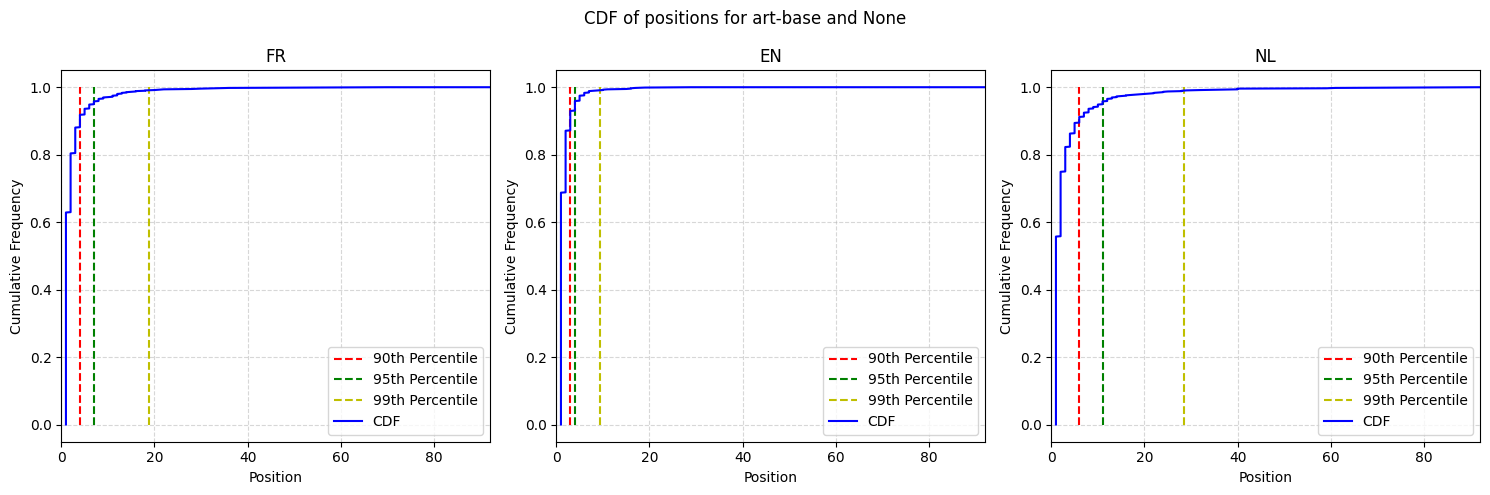

In [15]:
for model_name in models_name:
    cdf_positions(model_name, None)

In [16]:
getdf("basic", "content")

KeyError: 'basic'

KeyError: 'percentile_90'

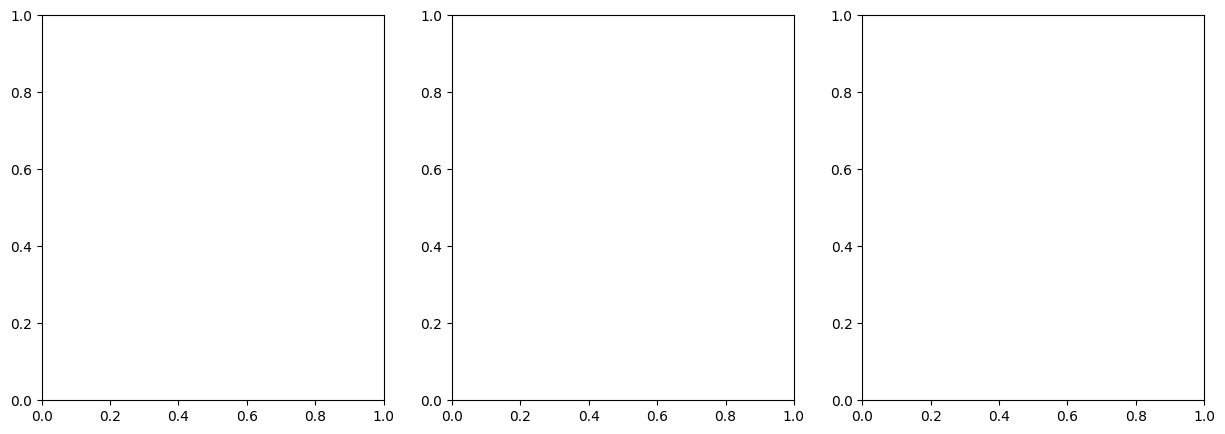

In [ ]:
plot_metric_per_model_per_lang("percentile_90")